In [1]:
###############################################################################
# Local Installs
###############################################################################
!pip install pygame
###############################################################################

     |████████████████████████████████| 18.3 MB 90 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
###############################################################################
import cv2
import glob
import natsort
import os
import sys
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
from sklearn.model_selection import train_test_split
from importlib import reload 
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras
###############################################################################

In [4]:
###############################################################################
# Local Imports
path = "/content/drive/MyDrive/Colab_Codes/Facial_reconstruction"
sys.path.append(path)
for root, directories, files in os.walk(path, topdown=False):
  for name in directories:
        sys.path.append(os.path.join(root, name))
#  


###############################################################################

In [5]:
import config as CNFG
import x_vis_normalized     as x_vis
import y_vis_normalized     as y_vis
import x_vis_scale_factor   as x_vis_sf
import y_vis_scale_factor   as y_vis_sf
import x_hid_normalized     as x_hid
import y_hid_normalized     as y_hid
import x_hid_scale_factor   as x_hid_sf
import y_hid_scale_factor   as y_hid_sf 
import neural_network       as NN
import show_animation       as ANIM

pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
###############################################################################
# Need to reload the dataset modules, if any updates are done to the datasets
def reload_all_text_modules():
  reload(x_vis)
  reload(y_vis)
  reload(x_vis_sf)
  reload(y_vis_sf)
  reload(x_hid)
  reload(y_hid)
  reload(x_hid_sf)
  reload(y_hid_sf)
  reload(CNFG)
#

reload_all_text_modules()
###############################################################################

In [7]:
###############################################################################
# Initialization
###############################################################################
# folder containing original images
original_images = CNFG.IMAGES_FOLDER + "\\" + CNFG.ORIGINAL_IMAGES_FOLDER
#print(original_images)

# list of images inside the original image folder
original_images = glob.glob(original_images+"\\*.png")
#print(original_images)
original_images = (natsort.natsorted(original_images))
# print(original_images)

total_images = len(original_images)

width  = 500
height = 500
x_hid_scale_fact = np.array(x_hid_sf.x_hid_scale_factor)
y_hid_scale_fact = np.array(y_hid_sf.y_hid_scale_factor)

x_vis_scale_fact = np.array(x_vis_sf.x_vis_scale_factor)
y_vis_scale_fact = np.array(y_vis_sf.y_vis_scale_factor)

hid_x = np.array(x_hid.x_hid_normalized)
hid_y = np.array(y_hid.y_hid_normalized)
vis_x = np.array(x_vis.x_vis_normalized)
vis_y = np.array(y_vis.y_vis_normalized)

vis_width_mat = np.ones(( len(vis_x) , 1)) * width

hid_width_mat = np.ones(( len(hid_x) , 1)) * width
hid_height_mat = np.ones(( len(hid_x) , 1)) * height

act_x_scaled = (vis_x * x_vis_scale_fact * vis_width_mat).astype(int)
act_y_scaled = (vis_y * y_vis_scale_fact * vis_width_mat).astype(int)

hid_x_scaled = (hid_x * x_hid_scale_fact * hid_width_mat).astype(int)
hid_y_scaled = (hid_y * y_hid_scale_fact * hid_width_mat).astype(int)

###############################################################################

In [8]:
###############################################################################
# Declaring data
###############################################################################
#x_train = np.asarray(x_vis.x_vis_normalized) # dim x m
#x_test  = np.asarray(x_hid.x_hid_normalized) # 1 x m
#y_train = np.asarray(y_vis.y_vis_normalized) # dim x m
#y_test  = np.asarray(y_hid.y_hid_normalized) # 1 x m

#vis_x  = np.asarray(x_vis.x_vis_normalized)
#hid_x  = np.asarray(x_hid.x_hid_normalized)

#y_vis_points = np.asarray(y_vis.y_vis_normalized)
#y_hid_points  = np.asarray(y_hid.y_hid_normalized)

print('Shape of vis_x - ', str(vis_x.shape))
print('Shape of hid_x - ', str(hid_x.shape))
print('Shape of vis_y - ', str(vis_y.shape))
print('Shape of hid_y - ', str(hid_y.shape))




###############################################################################

Shape of vis_x -  (195, 100)
Shape of hid_x -  (261, 100)
Shape of vis_y -  (195, 100)
Shape of hid_y -  (261, 100)


In [9]:
###############################################################################
# Dividing the data in test and train data. Ratio = 80:20

###############################################################################

In [10]:
# inp_x = np.array(vis_x).T # act_x_scaled
# out_x = np.array(hid_x).T # hid_x_scaled
inp_x = np.array(vis_x * x_vis_scale_fact).T # act_x_scaled
out_x = np.array(hid_x * x_hid_scale_fact).T # hid_x_scaled

inp_x = tf.stack(inp_x)
out_x = tf.stack(out_x)

In [11]:
input_neurons  = inp_x.shape[1]
output_neurons = out_x .shape[1]
print('Input neurons  x-points - ', str(input_neurons))
print('Output neurons x-points - ', str(output_neurons))

Input neurons  x-points -  195
Output neurons x-points -  261


In [12]:
###############################################################################
# 
###############################################################################
# define the keras model
model_x = Sequential()
#model.add(Dense(100, input_dim=input_length , activation='relu'))
model_x.add(Dense(100, input_dim=input_neurons , activation='relu'))
model_x.add(Dense(100, activation='relu'))

model_x.add(Dense(1000, activation='relu'))

model_x.add(Dense(output_neurons, activation='sigmoid'))
###############################################################################
# Error in x  =  221.17241379310346

In [13]:
# compile the keras model
#model_x.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_x.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy']) 


In [14]:
# fit the keras model on the dataset
model_save_path = path + '/temp'
x_epochs = 1000
period = int(x_epochs/500)
earlyStopping = EarlyStopping(monitor='accuracy', patience=10, verbose=0, mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='max')

checkpoint = keras.callbacks.ModelCheckpoint(model_save_path+'/x_checkpoint_{epoch:02d}.h5',
                                              save_best_only=True,
                                              monitor='accuracy',
                                              save_weights_only=True,
                                              mode="max",
                                              options=None)


history = model_x.fit(inp_x,out_x, epochs=1000,verbose=2, callbacks=[checkpoint], batch_size=20)

Epoch 1/1000
5/5 - 1s - loss: 0.0096 - accuracy: 0.0000e+00 - 1s/epoch - 249ms/step
Epoch 2/1000
5/5 - 0s - loss: 0.0020 - accuracy: 0.0000e+00 - 34ms/epoch - 7ms/step
Epoch 3/1000
5/5 - 0s - loss: 5.7266e-04 - accuracy: 0.0000e+00 - 34ms/epoch - 7ms/step
Epoch 4/1000
5/5 - 0s - loss: 4.7686e-04 - accuracy: 0.0000e+00 - 29ms/epoch - 6ms/step
Epoch 5/1000
5/5 - 0s - loss: 2.4507e-04 - accuracy: 0.2100 - 428ms/epoch - 86ms/step
Epoch 6/1000
5/5 - 0s - loss: 1.6130e-04 - accuracy: 0.5800 - 371ms/epoch - 74ms/step
Epoch 7/1000
5/5 - 0s - loss: 1.2473e-04 - accuracy: 0.4000 - 31ms/epoch - 6ms/step
Epoch 8/1000
5/5 - 0s - loss: 9.9434e-05 - accuracy: 0.7900 - 378ms/epoch - 76ms/step
Epoch 9/1000
5/5 - 0s - loss: 8.8727e-05 - accuracy: 0.7900 - 27ms/epoch - 5ms/step
Epoch 10/1000
5/5 - 0s - loss: 8.1654e-05 - accuracy: 0.7900 - 27ms/epoch - 5ms/step
Epoch 11/1000
5/5 - 0s - loss: 7.7015e-05 - accuracy: 0.7900 - 31ms/epoch - 6ms/step
Epoch 12/1000
5/5 - 0s - loss: 7.5772e-05 - accuracy: 0.7900

In [15]:
model_x.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               19600     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1000)              101000    
                                                                 
 dense_3 (Dense)             (None, 261)               261261    
                                                                 
Total params: 391,961
Trainable params: 391,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
# evaluate the modelaccuracy
_, accuracy = model_x.evaluate(inp_x, out_x)
print('Accuracy: %.2f' % (accuracy*100))

4/4 [==============================] - 0s 9ms/step - loss: 3.7938e-05 - accuracy: 0.8100
Accuracy: 81.00


In [17]:
x_hid_train_pred = (model_x.predict(inp_x, batch_size = 1) ).T

In [18]:
pred_hid_x_scaled = (x_hid_train_pred  * hid_width_mat).astype(int)

#pred_hid_x_scaled = (x_hid_train_pred * x_hid_scale_fact  * hid_width_mat).astype(int)
x_error_train =  np.sum ((abs(hid_x_scaled - pred_hid_x_scaled))) / len(hid_x_scaled) 
print('Error in x  = ', str(x_error_train))

Error in x  =  241.09195402298852


In [19]:
# best_model  = model_x.load_weights(model_save_path)

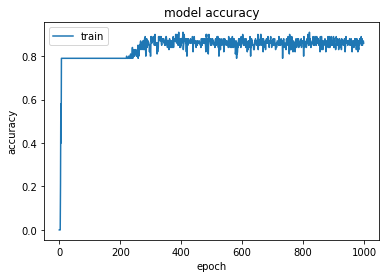

In [20]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [21]:
max(history.history['accuracy'])

0.9100000262260437

In [22]:
# model_10 = keras.models.load_model('/content/drive/MyDrive/Colab_Codes/Facial_reconstruction/temp/checkpoint_10.h5')

In [23]:
# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

In [25]:
#inp_y = np.array(vis_y).T
#out_y = np.array(hid_y).T

inp_y = np.array(vis_y ).T # act_x_scaled
out_y = np.array(hid_y ).T # hid_x_scaled

inp_y = tf.stack(inp_y)
out_y = tf.stack(out_y)

input_neurons  = inp_y.shape[1]
output_neurons = out_y .shape[1]
print('Input neurons  y-points - ', str(input_neurons))
print('Output neurons y-points - ', str(output_neurons))

Input neurons  y-points -  195
Output neurons y-points -  261


In [26]:
from keras.layers import BatchNormalization

In [38]:
###############################################################################
# 
###############################################################################
# define the keras model
model_y = Sequential()
model_y.add(Dense(100, input_dim=input_neurons , activation='relu'))
model_y.add(Dense(100, activation='relu'))
model_y.add(Dense(100, activation='relu'))
#model_y.add(Dense(100, activation='relu'))
#model_y.add(Dense(100, activation='relu'))
#model_y.add(Dense(100, activation='relu'))
model_y.add(Dense(1000, activation='relu'))
model_y.add(Dense(output_neurons, activation='sigmoid'))
###############################################################################

In [39]:
checkpoint = keras.callbacks.ModelCheckpoint(model_save_path+'/y_checkpoint_{epoch:02d}.h5',
                                              save_best_only=True,
                                              monitor='accuracy',
                                              save_weights_only=True,
                                              mode="max",
                                              options=None)

In [40]:
# compile the keras model 
# model_y.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_y.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

In [45]:
# fit the keras model on the dataset
history_y = model_y.fit(inp_y,out_y, epochs=1000, batch_size=20, callbacks=[checkpoint]) 

Epoch 1/1000
5/5 [==============================] - 0s 7ms/step - loss: 5.4069e-05 - accuracy: 1.0000
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 5.4330e-05 - accuracy: 1.0000
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 5.4353e-05 - accuracy: 1.0000
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 4.9461e-05 - accuracy: 1.0000
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 4.2731e-05 - accuracy: 1.0000
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 4.9859e-05 - accuracy: 1.0000
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 5.3553e-05 - accuracy: 1.0000
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 5.0865e-05 - accuracy: 1.0000
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 4.2738e-05 - accuracy: 1.0000
Epoch 10/1000
5/5 [==============================] - 0s 8ms/step - loss: 4.4155e-

In [47]:
# make class predictions with the model
predictions_y = (model_y.predict(inp_y, batch_size=1) ).T

In [48]:
# evaluate the modelaccuracy
_, accuracy = model_y.evaluate(inp_y, out_y)
print('Accuracy: %.2f' % (accuracy*100))

4/4 [==============================] - 0s 6ms/step - loss: 3.6349e-05 - accuracy: 1.0000
Accuracy: 100.00


In [49]:
pred_hid_y_scaled = (predictions_y* y_hid_scale_fact* hid_width_mat).astype(int)

#pred_hid_y_scaled = (predictions_y * y_hid_scale_fact * hid_width_mat).astype(int)
y_error =  np.sum (((hid_y_scaled - pred_hid_y_scaled)**2)**0.5) / len(hid_y_scaled)
print('Error in y  = ', str(y_error))

Error in y  =  205.08045977011494


In [50]:
# folder containing original images
original_images = CNFG.IMAGES_FOLDER + "\\" + CNFG.ORIGINAL_IMAGES_FOLDER

# list of images inside the original image folder
original_images = glob.glob(original_images+"\\*.png")
original_images = (natsort.natsorted(original_images))

img_count = 0
# folder containing original images
original_images_path = "/content/drive/MyDrive/Colab_Codes/Facial_reconstruction/images/original"
original_images = []

for root, directories, files in os.walk(original_images_path, topdown=False):
  for name in files:
        #print(os.path.join(root, name))
        original_images.append(os.path.join(root, name))
#
original_images = (natsort.natsorted(original_images))


In [51]:
####################
def create_file(dataset_name ,dataset):
    file_name ="/content/drive/MyDrive/Colab_Codes/Facial_reconstruction/"+dataset_name +'keras_.py'
    #print(' writing file - ', file_name)
    f = open(file_name, 'w+')  # 
    f.write(dataset_name)
    f.write(' = ' )
    f.write(str(eval(dataset_name)))
    f.close()
        
########################

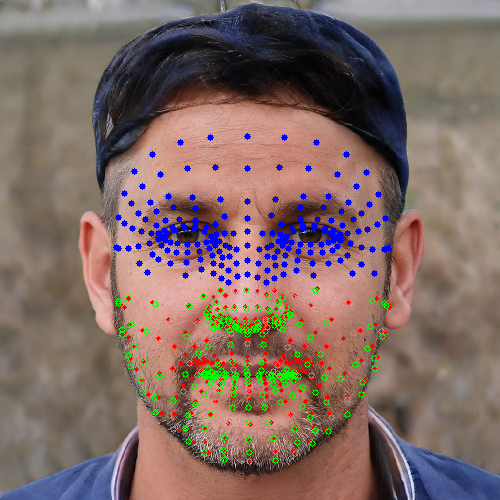

In [52]:
image = cv2.imread('/content/drive/MyDrive/Colab_Codes/Facial_reconstruction/images/original/1.png')
img_bgr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for vals in range(0, len(pred_hid_x_scaled)):
  x1 = pred_hid_x_scaled[vals][0]
  y1 = pred_hid_y_scaled[vals][0]
  p_h = cv2.circle(image, (x1, y1), 2, (0, 0, 255), -1)
  a_h = cv2.circle(image, (x1, y1), 2, (0, 0, 255), -1)
#
for vals in range(0, len(act_x_scaled)):
    x0 = act_x_scaled[vals][0]
    y0 = act_y_scaled[vals][0]
    
    a_v = cv2.circle(image, (x0, y0), 3, (255, 0, 0), -1)
#
for vals in range(0, len(hid_x_scaled)):
    x0 = hid_x_scaled[vals][0]
    y0 = hid_y_scaled[vals][0]
    
    a_h = cv2.circle(image, (x0, y0), 3, (0, 255, 0), 0)
#
cv2_imshow(image)